**Примечание:** ячейки кода с комментарием ```# illustration``` служат для демонстрации промежуточных шагов алгоритма и не влияют на его работу!

In [1]:
%pip install numpy-stl


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
from stl import mesh
from mpl_toolkits import mplot3d
from matplotlib import pyplot
import cv2
from matplotlib import pyplot as plt
from draw import *
from mesh_to_img import *
from thread_search import *

Загрузим модель в программу с помощью библиотеки ```numpy-stl``` и отобразим сетку $M=$ ```nippel_mesh``` с помощью функции ```plot_mesh()```, определенной в модуле ```draw```. 

Далее все вершины сетки $M$ будем обозначать через $v_i = (x_i, \, y_i, z_i)$.

Будем считать, что ось вращения ниппеля совпадает с осью $Oy$.

In [3]:
nippel_mesh = mesh.Mesh.from_file('../stl/nippel_1.stl')
rot_axis = np.array([0.0, 1.0, 0.0])

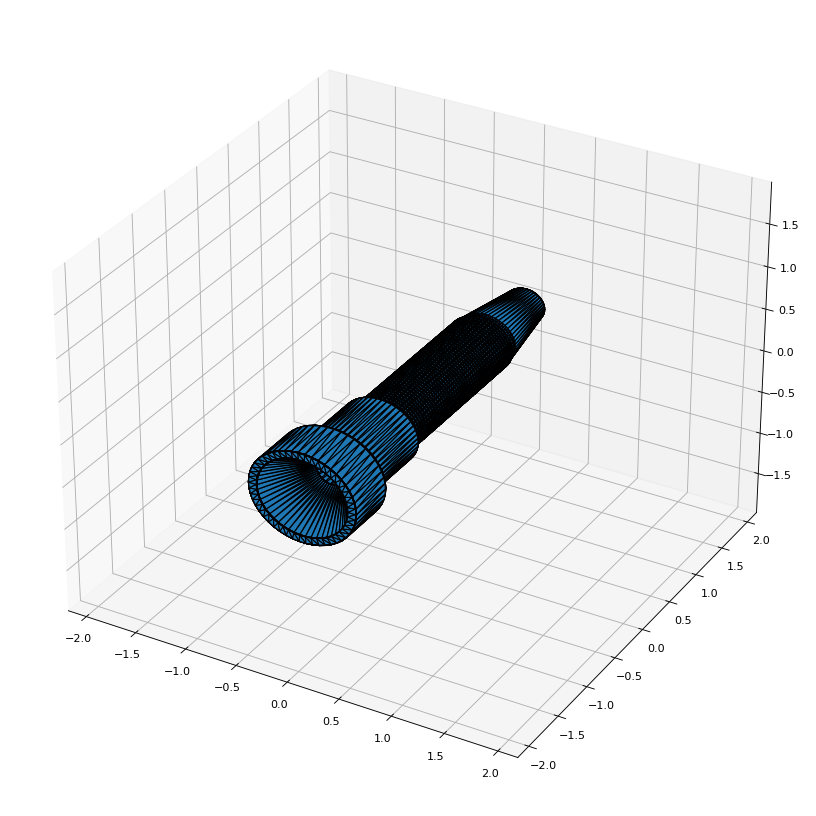

In [19]:
# illustration
plot_mesh(nippel_mesh)

Функция ```get_img_from_mesh()``` отрисовывает все полигоны $p_i \in M$ модели. Порядок отрисовки зависит от порядка полигонов в объекте ```nippel_mesh```.

При отрисовке вершина $v_i$ сетки проецируется на плоскость $xOy:$ $v_i \to (v_i + t) \cdot s$, где $s =$ ```scale```, $t=|\min\limits_i\{ v_i \}|$.

In [5]:
scale = 800

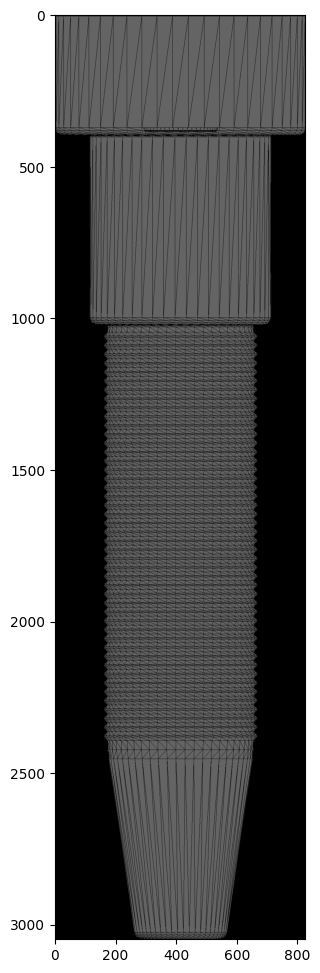

In [20]:
# illustration
mesh_img = get_img_from_mesh(nippel_mesh, scale)
show_img(mesh_img)
shape_bgr = mesh_img.shape

Для кажого полигона $p_i \in M$ опредлен вектор нормали $\vec{n}_i$. С помощью функции ```get_angles()``` посчитаем углы $\alpha_i$ между векторами $\vec{n}_i$ и вектором $(0, \, 1, \,0 )$.

In [7]:
angles = get_angles(nippel_mesh, rot_axis)

Разделим все полигоны на множества $P_{\alpha_j}$ с одинаковыми углами $\alpha_j$. Множества $P_{\alpha_i}$ будем хранить в виде списков в словаре ```polygon_lists```. Ключами в словаре выступают углы $\alpha_i$ из массива ```angles```.

In [8]:
polygon_lists = make_polygon_lists(angles)

С помощью функции ```get_angles_map()``` отрисуем модель. На рисунке полигоны из одного множества $P_{\alpha_j}$ покрашены в один цвет.

Так как цвета генерируются случайным образом, можно запустить ячейку пару раз для большей наглядности

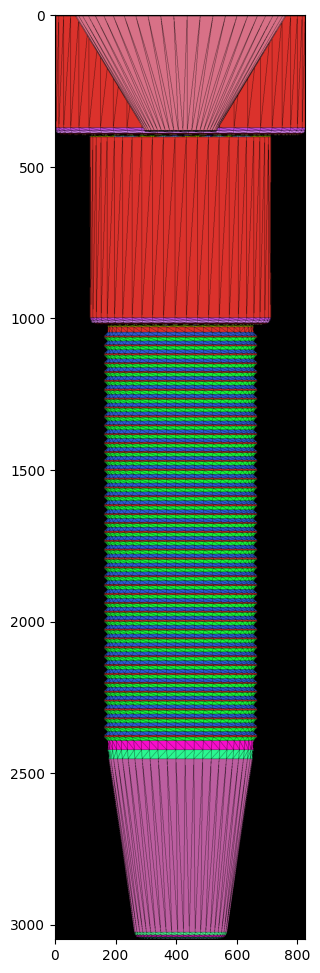

In [21]:
# illustration
angles_map_img = get_angles_map(nippel_mesh, scale, polygon_lists)
show_img(angles_map_img)

Для каждого угла $\alpha_j$ получим маску $m_{\alpha_j}$, которая выделяет только участки с полигонами из $P_{\alpha_j}$.

In [10]:
binary_masks = []
for angle in polygon_lists.keys():
    binary_masks.append(get_mask(nippel_mesh, angle, scale, polygon_lists))

Так выглядит маска $m_{90^\circ}$ для полигонов $p \in P_{90^\circ}$ с нормалями перпендикулярными оси $Oy$:

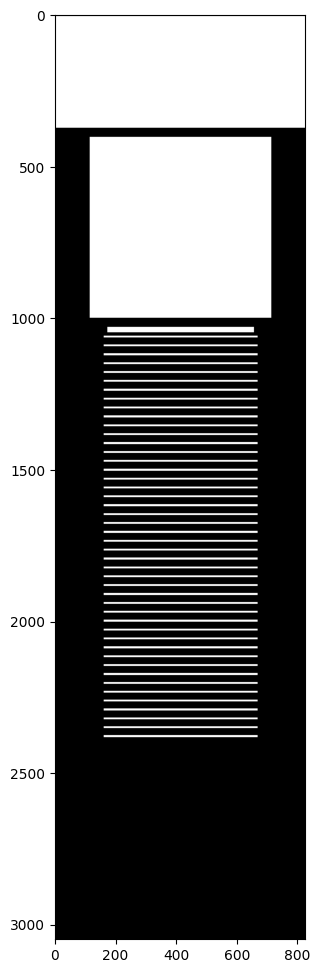

In [11]:
#illustration
show_img(binary_masks[0])

Теперь внутри каждой маски $m_{\alpha_j}$ найдем компоненты связности и выделим их контурами. В этой же функции уберем маски, содержащие небольшое количество компонент (< ```min_size```).

In [12]:
min_size = 10
contours_on_masks = find_contours_on_masks(binary_masks, min_size)

Отобразим найденные контуры на маске $m_{90^\circ}$:

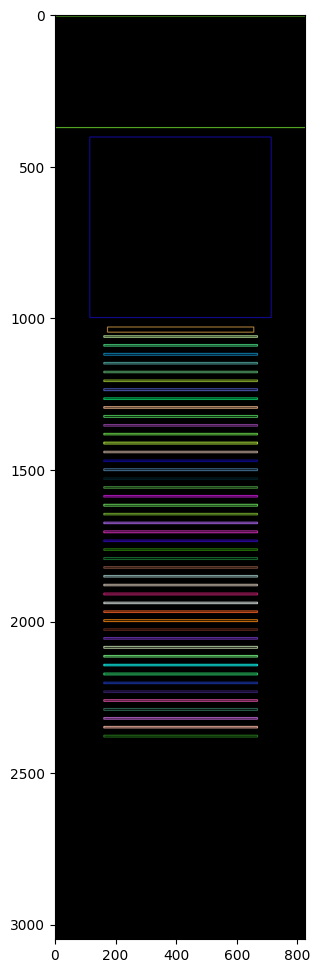

In [22]:
# illustration
contours_img = np.zeros(shape_bgr, dtype=np.uint8)
contours_img = draw_contours(contours_img, contours_on_masks[0], 'rand', 2)
show_img(contours_img)

Теперь переберем все маски $m_{\alpha_j}$ и оставим на них только те контуры, которые повторяются несколько раз ($\geqslant$ ```min_size```). Объединим все такие контуры в один список ```thread_contours```. Для этого используем функцию ```find_thread_contours()```.

In [14]:
min_size = 10
thread_contours = find_thread_contours(contours_on_masks, min_size)

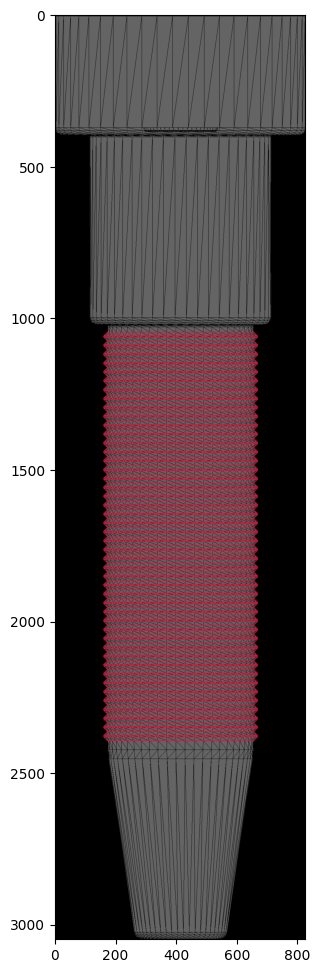

In [23]:
# illustration
thread_contours_img = mesh_img.copy()
for contours in thread_contours:
    thread_contours_img = draw_contours(thread_contours_img, contours, nice_red, 2)
show_img(thread_contours_img)

Определим границы начала и конца резьбы на изображени.

In [16]:
thread_start, thread_end = find_thread_bounds(thread_contours, shape_bgr[0], 0)

Покажем начало и конец резьбы на изображении ниппеля.

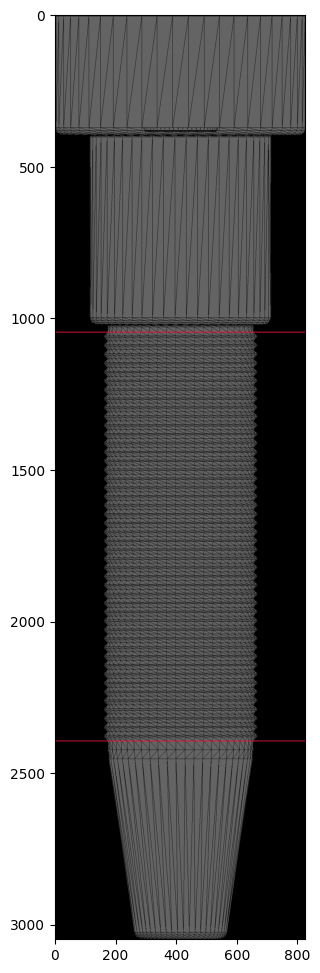

In [24]:
# illustration
thread_bound_img = mesh_img.copy()
cv2.line(thread_bound_img, (0, thread_start), (shape_bgr[1], thread_start), nice_red, 2)
cv2.line(thread_bound_img, (0, thread_end), (shape_bgr[1], thread_end), nice_red, 2) 
show_img(thread_bound_img)

Переводим эти границы в координаты модели

In [18]:
thread_start_stl = thread_start / scale - abs(nippel_mesh.min_[1])
thread_end_stl = thread_end / scale - abs(nippel_mesh.min_[1])
print('Thread start: y =', '%.3f' % thread_start_stl)
print( 'Thread end: y = ', '%.3f' % thread_end_stl)

Thread start: y = -0.598
Thread end: y =  1.088
